<a href="https://colab.research.google.com/github/tevfikcagridural/student-success/blob/master/Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelling

---

TODO: write an intro

---

In [1]:
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer 

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/tevfikcagridural/student-success/master/data/interim/engineered_feature.csv')

# Train Test Split

In [3]:
X = data.drop(columns='final_result')
y = data['final_result']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [5]:
X_train.shape, X_test.shape  

((24409, 26), (8137, 26))

In [6]:
y_train.shape, y_test.shape

((24409,), (8137,))

In [7]:
round(y_train.value_counts() / y_train.shape[0], 2)

Pass           0.38
Withdrawn      0.31
Fail           0.22
Distinction    0.09
Name: final_result, dtype: float64

# Preprocessing

In [8]:
def X_preprocessor():
  """Builds the column tranformer of X
  returns column transformer to be used to transform X"""
  
  # Identify ordinal features to be used in Ordinal Encoder
  ordinal_features = ['age_band', 'highest_education', 'imd_band']

  # Identify nominal and binary features to be used in One Hot Encoder
  nominal_features = ['code_module_presentation', 'region', 'gender']

  # Identify numerical features to be scaled
  numerical_features = ['num_of_prev_attempts', 'studied_credits', 'disability',
                        'module_presentation_length', 'date_registration', 
                        'first_score','mean_score', 'last_score', 
                        'min_weight_score', 'max_weight_score','has_exam', 
                        'subpage_clicks', 'forumng_clicks', 'homepage_clicks',
                        'oucontent_clicks', 'ouwiki_clicks', 'quiz_clicks', 
                        'resource_clicks','url_clicks']


  # Make a piple for Ordinal features to be encoded and impute
  ordinal_procedure = make_pipeline(
      SimpleImputer(strategy='most_frequent'), # To impute imd_band NaN values 
      OrdinalEncoder())
  
  # Set final transformer for all features and their related transformations
  preprocessor = make_column_transformer((ordinal_procedure, ordinal_features),
                          (OneHotEncoder(drop='first'), nominal_features),
                          (StandardScaler(), numerical_features),
                          remainder='passthrough')


  return preprocessor

# Models
- Logistic regression
- K Nearest Neighbors
- Support Vector Machine
- Random Forest
- Gradient Boost
- Naive Bayes

I'll build each model with some basic hyperparameter tuning and compare their results to decide which model to build with more sophisticated hyperparameter tuning. 
My data is both multi-class and imbalanced. I should evaluate and choose my model considering this.


Reasons to chose these metrics:


---

TODO: Explain the process

1.   MCC
2.   ACC



F1 will be computed with micro-average https://www.kdnuggets.com/2018/06/right-metric-evaluating-machine-learning-models-2.html

---

In [9]:
def estimator_metrics(estimator):
  """Builds estimator in a random search cv with given parameters
  then calculates the best estimators' metric."""

  # Get the name of the model
  model_name = str(type(estimator)).split('.')[-1][:-2]

  # Build a pipline with estimator and column transformator
  model_pipe = Pipeline([('preprocessor', X_preprocessor()),
                         (model_name, estimator)])
  
  # Fit the data
  model_pipe.fit(X_train, y_train)

  # Predict train data with the estimator
  y_predict_train = model_pipe.predict(X_train)

  # Calculate the train metrics of the model
  optimal_mcc_train = matthews_corrcoef(y_train, y_predict_train)
  optimal_accuracy_train = accuracy_score(y_train, y_predict_train)
  optimal_f1_train = f1_score(y_train, y_predict_train, average='micro')
  optimal_conf_matx_train = confusion_matrix(y_train, y_predict_train)

  # Predict test data with the estimator
  y_predict_test = model_pipe.predict(X_test)

  # Calculate the test metrics of the model
  optimal_mcc_test = matthews_corrcoef(y_test, y_predict_test)
  optimal_accuracy_test = accuracy_score(y_test, y_predict_test)
  optimal_f1_test = f1_score(y_test, y_predict_test, average='micro')
  optimal_conf_matx_test = confusion_matrix(y_test, y_predict_test)

  # Set metrics as dataframe
  metrics =  np.array([[model_name,
                       'train',
                       optimal_mcc_train,
                       optimal_accuracy_train, 
                       optimal_f1_train,
                       optimal_conf_matx_train],
                       [model_name,
                       'test',
                       optimal_mcc_test,
                       optimal_accuracy_test, 
                       optimal_f1_test,
                       optimal_conf_matx_test]], dtype='object')

  return metrics

In [10]:
# Logistic regression
lr = LogisticRegression(n_jobs=-1)

lr_metrics = estimator_metrics(lr)

In [11]:
# K Nearest Neighbor
knn = KNeighborsClassifier(n_jobs=-1)

knn_metrics = estimator_metrics(knn)

In [12]:
# Support Vector Machine
svc = SVC(C=1.0)

svc_metrics = estimator_metrics(svc)

In [13]:
# Random Forest
rf = RandomForestClassifier(n_jobs=-1)

rf_metrics = estimator_metrics(rf)

In [14]:
# Gradient Boost
gb = GradientBoostingClassifier()

gb_metrics = estimator_metrics(gb)

In [15]:
# Naive Bayes
nb = GaussianNB()

nb_metrics = estimator_metrics(nb)

# Comparison of Models
---

**TODO: explain the process**


---

In [57]:
# Build a Dataframe to store the evaluation metrics
all_metrics = np.concatenate((lr_metrics, knn_metrics, 
                              svc_metrics, rf_metrics, 
                              gb_metrics, nb_metrics))

df_evaluation = pd.DataFrame(all_metrics, 
                             columns=['Model', 'Split', 'MCC', 'Accuracy',
                                      'F1', 'Confusion Matrix'])
df_evaluation = df_evaluation.set_index(['Model', 'Split'])

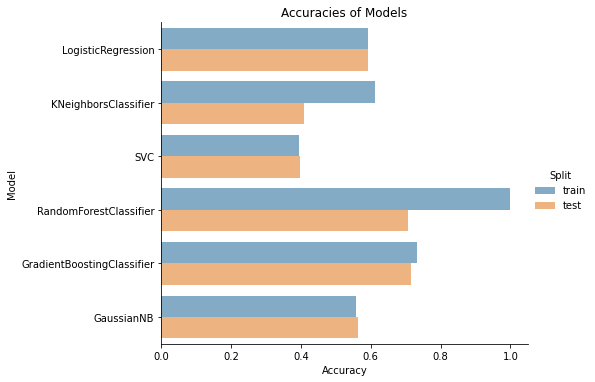

In [59]:
_ = sns.catplot(data=df_evaluation.reset_index(), kind="bar",
                x="Accuracy", y="Model", hue="Split",
                palette="tab10", alpha=.6, aspect=1.5)
_ = plt.title("Accuracies of Models")

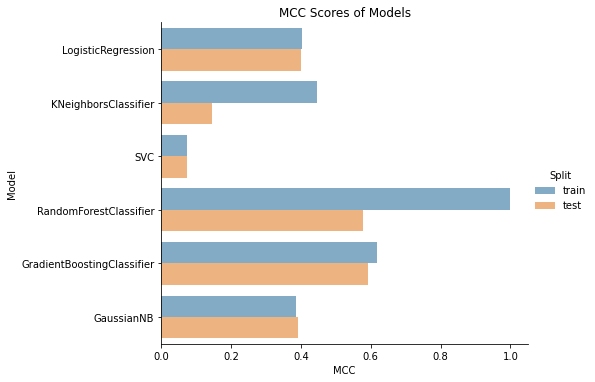

In [18]:
_ = sns.catplot(data=df_evaluation.reset_index(), kind="bar",
                x="MCC", y="Model", hue="Split",
                palette="tab10", alpha=.6, aspect=1.5)
_ = plt.title("MCC Scores of Models")

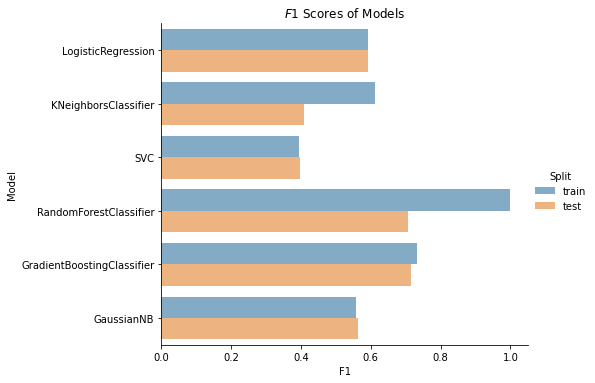

In [19]:
_ = sns.catplot(data=df_evaluation.reset_index(), kind="bar",
                x="F1", y="Model", hue="Split",
                palette="tab10", alpha=.6, aspect=1.5)
_ = plt.title("$F1$ Scores of Models")

So far the best options seems to be Gradient Boost and Random Forest. Random Forest obvisouly overfitted but this can be tuned.

In [20]:
"""Resource: https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

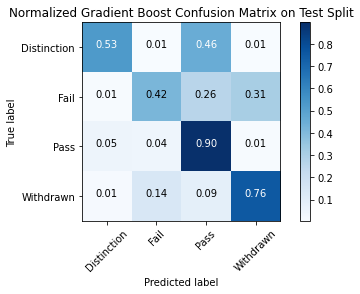

In [72]:
class_names = ['Distinction', 'Fail', 'Pass', 'Withdrawn']

plot_confusion_matrix(df_evaluation.loc['GradientBoostingClassifier', 'test']['Confusion Matrix'],
                      classes=class_names,
                      title='Normalized Gradient Boost Confusion Matrix on Test Split',
                      normalize=True)

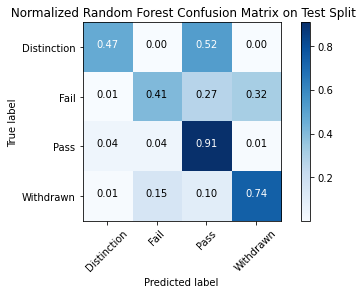

In [76]:
plot_confusion_matrix(df_evaluation.loc['RandomForestClassifier', 'test']['Confusion Matrix'],
                      classes=class_names,
                      title=' Normalized Random Forest Confusion Matrix on Test Split',
                      normalize=True)

Both estimator had problems on distinction and fail labels. They misclassifed them as pass and withdrawn respectively. Which actually makes sense. So I'll work on these and and compare the results again with tuned hyperparamaters with bayesian optimization

# Hyperparameter Tuning
I'll use Bayesian Optimization for hyperparameter tuning.


In [23]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=4ca7e250fa3f1da4af2a6e3190c811d86aba84f2888ef55c92b6db9ff1c17125
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [24]:
from bayes_opt import BayesianOptimization

## Random Forest Tuning
---

<div class="span5 alert alert-info">
TODO: Explain what you will do
<div>

---

In [25]:
"""Resource: https://github.com/fmfn/BayesianOptimization/blob/master/examples/sklearn_example.py
tuned accordingly to this problem's needs"""
def rfc_cv(n_estimators, criterion, min_samples_split, max_features, data, targets):
    """Random Forest cross validation.
    This function will instantiate a random forest classifier with parameters
    n_estimators, min_samples_split, and max_features. Combined with data and
    targets this will in turn be used to perform cross validation. The result
    of cross validation is returned.
    Our goal is to find combinations of n_estimators, min_samples_split, and
    max_features that minimzes the log loss.
    """
    estimator = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        min_samples_split=min_samples_split,
        max_features=max_features,
        n_jobs=-1
    )
    scorer = make_scorer(matthews_corrcoef)

    cval = cross_val_score(estimator, data, targets,
                           scoring=scorer, cv=4)
    return cval.mean()

    
def optimize_rfc(data, targets):
    """Apply Bayesian Optimization to Random Forest parameters."""
    def rfc_crossval(n_estimators, criterion, min_samples_split, max_features):
        """Wrapper of RandomForest cross validation.
        Notice how we ensure n_estimators and min_samples_split are casted
        to integer before we pass them along. Moreover, to avoid max_features
        taking values outside the (0, 1) range, we also ensure it is capped
        accordingly.
        """
        if int(criterion) == 1:
          criterion = 'gini'
        elif int(criterion) == 2:
          criterion = 'entropy'
        else:
            raise MyError("Criterion is out of bounds. Must be either 1 or 2")

        return rfc_cv(
            n_estimators=int(n_estimators),
            criterion=criterion,
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (100, 500),
            "criterion": (1, 3),
            "min_samples_split": (10, 50),
            "max_features": (0.1, 0.999),
        },
        verbose=2
    )
    optimizer.maximize(init_points=2, n_iter=10)

    print("Final result:", optimizer.max)

In [26]:
# Create the column transformer and fit it to X_train
col_transformer = X_preprocessor().fit(X_train)

# Transform X_train
X_train_transformed = col_transformer.transform(X_train)

In [27]:
optimize_rfc(X_train_transformed, y_train)

|   iter    |  target   | criterion | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.5922   |  1.608    |  0.3537   |  11.88    |  285.1    |
|  2        |  0.5902   |  2.316    |  0.5441   |  36.2     |  301.0    |
|  3        |  0.5839   |  2.995    |  0.8605   |  48.89    |  100.1    |
|  4        |  0.5933   |  2.483    |  0.158    |  10.14    |  498.9    |
|  5        |  0.5921   |  2.878    |  0.5453   |  10.21    |  497.7    |
|  6        |  0.5839   |  1.279    |  0.8746   |  49.03    |  499.9    |
|  7        |  0.5848   |  1.589    |  0.8451   |  10.04    |  281.4    |
|  8        |  0.5943   |  1.409    |  0.3088   |  10.45    |  388.1    |
|  9        |  0.5944   |  2.741    |  0.1802   |  10.52    |  414.2    |
|  10       |  0.5935   |  1.017    |  0.2844   |  11.0     |  422.5    |
|  11       |  0.5939   |  2.987    |  0.3416   |  11.56    |  415.5    |
|  12       |  0.5923   |  2.97     | 

In [94]:
# Build the tuned random forest with tuned hyperparameters
best_rf = RandomForestClassifier(n_estimators=414, 
                                 criterion = 'entropy',
                                 max_features=0.1802,
                                 min_samples_split=10,
                                 n_jobs=-1)

In [95]:
# Fit estimator to train data
best_rf.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features=0.1802,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=414,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [96]:
# Transform X test
X_test_transformed = col_transformer.transform(X_test)

# Predict y_test
rf_y_pred_test = best_rf.predict(X_test_transformed)

### Changes of te metrics after hyperparameter tuning

In [97]:
# Compute the accuracy and MCC of Best RF
rf_accuracy = accuracy_score(y_test, rf_y_pred_test)
rf_mcc = matthews_corrcoef(y_test, rf_y_pred_test)

In [98]:
# Accuracy Change
rf_accuracy - df_evaluation.loc['RandomForestClassifier', 'test']['Accuracy']

0.006759247880053998

In [99]:
# MCC Change
rf_mcc - df_evaluation.loc['RandomForestClassifier', 'test']['MCC']

0.010319611797146688

In [107]:
# Final Metrics
rf_accuracy, rf_mcc

(0.7143910532137151, 0.5891124647055381)

## Gradient Boost Tuning

---

TODO: Comment the functions and explain what do they do

---

In [30]:
def gbc_cv(n_estimators, learning_rate, min_samples_split, max_features, data, targets):
    estimator = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        max_features=max_features
    )
    
    scorer = make_scorer(matthews_corrcoef)

    cval = cross_val_score(estimator, data, targets,
                           scoring=scorer, cv=4)
    return cval.mean()

    
def optimize_gbc(data, targets):
    def gbc_crossval(n_estimators, learning_rate, min_samples_split, max_features):
        
        return gbc_cv(
            n_estimators=int(n_estimators),
            learning_rate=learning_rate,
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=gbc_crossval,
        pbounds={
            "n_estimators": (100, 500),
            "learning_rate": (0.1, 1),
            "min_samples_split": (10, 50),
            "max_features": (0.1, 0.999),
        },
        verbose=2
    )
    optimizer.maximize(init_points=2, n_iter=10)

    print("Final result:", optimizer.max)

In [31]:
optimize_gbc(X_train_transformed, y_train)

|   iter    |  target   | learni... | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.56     |  0.9956   |  0.405    |  15.44    |  112.5    |
|  2        |  0.5838   |  0.4546   |  0.5688   |  35.53    |  263.0    |
|  3        |  0.5749   |  0.4216   |  0.7538   |  12.38    |  498.8    |
|  4        |  0.5944   |  0.1389   |  0.5787   |  37.63    |  266.4    |
|  5        |  0.574    |  0.4225   |  0.3894   |  49.97    |  422.4    |
|  6        |  0.5609   |  0.914    |  0.5809   |  49.93    |  104.9    |
|  7        |  0.5843   |  0.3014   |  0.8391   |  10.16    |  361.8    |
|  8        |  0.553    |  0.8656   |  0.6608   |  49.82    |  334.0    |
|  9        |  0.5547   |  0.8006   |  0.8487   |  49.88    |  499.4    |
|  10       |  0.5921   |  0.2077   |  0.6928   |  49.9     |  184.7    |
|  11       |  0.5938   |  0.1604   |  0.5091   |  10.37    |  440.4    |
|  12       |  0.5622   |  0.6454   | 

In [100]:
# Build the tuned Gradient Boosting Classifer
best_gb = GradientBoostingClassifier(learning_rate= 0.1389, 
                                     max_features= 0.5787, 
                                     min_samples_split= 37,
                                     n_estimators= 266)

In [101]:
# Fit Estimator to train data
best_gb.fit(X_train_transformed, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1389, loss='deviance', max_depth=3,
                           max_features=0.5787, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=37,
                           min_weight_fraction_leaf=0.0, n_estimators=266,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [102]:
# Predict y_test
gb_y_pred_test = best_gb.predict(X_test_transformed)

### Changes of metrics after hyperparameter tuning

In [103]:
# Compute the mecric for tuned Gradient Boosting
gb_accuracy = accuracy_score(y_test, gb_y_pred_test)
gb_mcc = matthews_corrcoef(y_test, gb_y_pred_test)

In [104]:
# Accuracy Change
gb_accuracy - df_evaluation.loc['GradientBoostingClassifier', 'test']['Accuracy']

0.0040555487280324876

In [105]:
# MCC Cnage
gb_mcc - df_evaluation.loc['GradientBoostingClassifier', 'test']['MCC']

0.005648400261429987

In [106]:
# Final metrics
gb_accuracy, gb_mcc

(0.7199213469337594, 0.5969379232347135)